Train_mobilenet.py

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train = np.repeat(x_train, 3, axis = -1)
x_test = np.repeat(x_test, 3, axis = -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
BATCH_SIZE = 32
Autotune = tf.data.experimental.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(preprocess, num_parallel_calls = Autotune)
    .batch(BATCH_SIZE)
    .prefetch(Autotune)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(preprocess, num_parallel_calls = Autotune)
    .batch(BATCH_SIZE)
    .prefetch(Autotune)
)

base_model = tf.keras.applications.VGG16(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)
base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = 1
)

model.save('vgg16_mnist_model.h5')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 379s 195ms/step - accuracy: 0.7139 - loss: 0.9396 - val_accuracy: 0.9427 - val_loss: 0.1995


Saved artifact at '/tmp/tmpkl_6lw_o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133227046496848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046497424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046496656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046497232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046498576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046497808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046498384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046499152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046499536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133227046500496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1332270464

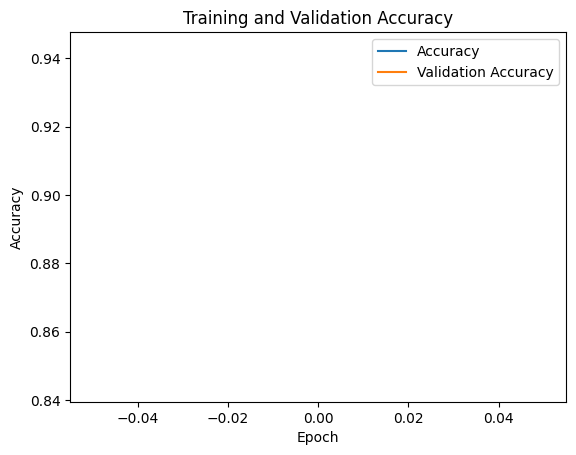

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('vgg16_mnist_model.tflite', 'wb') as f:
    f.write(tflite_model)

plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

convert_tflite.py

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.lite.python.interpreter import Interpreter
import tensorflow_datasets as tfds
import cv2

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test[:10,:,:]
y_test = y_test[:10]

x_test = x_test/255.0
x_test = np.expand_dims(x_test, -1)
x_test = np.repeat(x_test, 3, axis = -1)

interpreter = Interpreter(model_path="vgg16_mnist_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

predictions = []
for i in range(len(x_test)):
    input_data = cv2.resize(x_test[i], (224, 224))
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(np.argmax(output_data))


predictions = np.array(predictions)
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'TFLite Model Accuracy: {accuracy * 100:.2f}%')

TFLite Model Accuracy: 80.00%


run_inference.py

In [20]:
import tensorflow as tf
import numpy as np
import time
import cv2

interpreter = tf.lite.Interpreter(model_path='vgg16_mnist_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=-1)
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    img = np.repeat(img, 3, axis=-1)
    img = img / 255.0
    return img

image_path = 'test_image.png'
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)
print('Predicted class:', predicted_class)

times = []
for i in range(20):
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    delta = time.time() - start_time
    times.append(delta)

avg_time = np.mean(times)
fps = 1 / avg_time
print(f"Average time per inference: {avg_time:.4f} seconds, FPS: {fps:.2f}")

Predicted class: 7
Average time per inference: 0.5001 seconds, FPS: 2.00
